In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import networkx as nx
from scipy.special import softmax
from tqdm import tqdm
from random import shuffle
import copy
from collections import defaultdict
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from uga import UGA,UGA_RSL
from trm import TRM
from lp import LP
from local_ratio import Local_Ratio
from hs import HS,RSL
data = pd.read_csv('nyc_citi.csv')
data = data.loc[[type(i)==str for i in data['start station name']]]
data = data.loc[[type(i)==str for i in data['end station name']]]
data.starttime=data.starttime.apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data.stoptime=data.stoptime.apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
#data.head()

In [2]:

def build_station_graph(data,starttime,stoptime):
    graphx=nx.Graph()
    filtered_data = data[(data['starttime']>=starttime) & (data['starttime']<=stoptime)]
    locations = list(set(filtered_data['start station name']).union(filtered_data['end station name']))
    vertices = pd.Series([{}]*len(locations),index=locations)
    for loc in locations:
        vertices[loc] = {'change':0,'x':np.random.random(),'y':np.random.random(),'type':''}
        
    for i in filtered_data['start station name']:
        vertices[i]['change'] -= 1
    for i in filtered_data['end station name']:
        vertices[i]['change'] += 1
    for loc in locations:
        if vertices[loc]['change'] > 0:
            vertices[loc]['type'] = 'overflow'
        if vertices[loc]['change'] < 0:
            vertices[loc]['type'] = 'underflow'
    vertices = vertices.loc[[x['type'] != '' for x in vertices]]
    for vertex in vertices.index:
        graphx.add_node(vertex,bipartite=int(vertices[vertex]['type']=='overflow'))
    #print(vertices)
    nx.set_node_attributes(graphx, {i: vertices[i] for i in vertices.index}) 
    for i in range(len(vertices.index)):
        for j in range(len(vertices.index)):
            if vertices[vertices.index[i]]['type'] != vertices[vertices.index[j]]['type'] and not graphx.has_edge(i,j):
                x1=vertices[vertices.index[i]]['x']
                y1=vertices[vertices.index[i]]['y']
                x2=vertices[vertices.index[j]]['x']
                y2=vertices[vertices.index[j]]['y']
                graphx.add_weighted_edges_from([(vertices.index[i],vertices.index[j],euc_dis(x1,y1,x2,y2))])
    return graphx

def build_cwgraph(data,starttime,stoptime):
    cgraph =  build_station_graph(data,starttime,stoptime)
    overflow = {node:{} for node in graph.nodes() if graph.nodes[node]['type']=='overflow'}
    underflow = {node:{} for node in graph.nodes() if graph.nodes[node]['type']=='underflow'}


    cgraph = cloned_station_vertices(graph)
    workers = {str(i):{
                    'type':'worker',
                'xs':np.random.random(),
                'ys':np.random.random(),
                'xe':np.random.random(),
                'ye':np.random.random()
                } for i in range(np.min([len(underflow), len(overflow)]))}
    cwgraph = copy.deepcopy(cgraph)
    #print(cwgraph.nodes)
    cwgraph.add_nodes_from(workers.keys())
    nx.set_node_attributes(cwgraph, workers) 
    cwgraph.add_edges_from([(w,s) for w in workers for s in cgraph.nodes])
    
    return cwgraph

def cloned_station_vertices(graphx):
    nodes = list(graphx.nodes())
    for node in nodes:
        if graphx.nodes[node]['change']>1:
            for i in range(graphx.nodes[node]['change']-1):
                i = i+1
                graphx.add_nodes_from([(str(node)+str(i),graphx.nodes[node])],bipartite=int(graphx.nodes[node]['bipartite']))
                new_node_name = str(node)+str(i)
                new_node_data = graphx.nodes[new_node_name]
                for node_ in graphx.nodes:
                    if new_node_data['bipartite'] != graphx.nodes[node_]['bipartite']:
                        x1=new_node_data['x']
                        y1=new_node_data['y']
                        x2=graphx.nodes[node_]['x']
                        y2=graphx.nodes[node_]['y']
                        graphx.add_weighted_edges_from([(node_,new_node_name,euc_dis(x1,y1,x2,y2))])
    return graphx
                
def draw_bipartite(B):
    l, r = nx.bipartite.sets(B)
    pos = {}

    # Update position for node from each group
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, index)) for index, node in enumerate(r))

    nx.draw(B, pos=pos)
    plt.show()
def draw_graph(B):
    pos = {}

    # Update position for node from each group
    pos.update((node, (B.nodes[node]['x'], B.nodes[node]['y'])) for node in list(B.nodes))
    nx.draw(B, pos=pos)
    plt.show()
                
def euc_dis(x1,y1,x2,y2):
    return ((x1-x2)**2+(y1-y2)**2)**.5         

In [3]:

graph = build_station_graph(data,data.loc[0,'starttime'],data.loc[100,'stoptime'])
#print(graph['E 6 St & Avenue D'])
overflow = {node:{} for node in graph.nodes() if graph.nodes[node]['type']=='overflow'}
underflow = {node:{} for node in graph.nodes() if graph.nodes[node]['type']=='underflow'}


cgraph = cloned_station_vertices(graph)
workers = {str(i):{
                'type':'worker',
               'xs':np.random.random(),
               'ys':np.random.random(),
               'xe':np.random.random(),
               'ye':np.random.random()
              } for i in range(np.min([len(underflow), len(overflow)]))}
cwgraph = copy.deepcopy(cgraph)
#print(cwgraph.nodes)
cwgraph.add_nodes_from(workers.keys())
nx.set_node_attributes(cwgraph, workers) 
cwgraph.add_edges_from([(w,s) for w in workers for s in cgraph.nodes])
worker = {node:{} for node in cwgraph.nodes() if cwgraph.nodes[node]['type']=='worker'}
print(len(worker))
#print(cwgraph.nodes)

58


In [4]:
class Testing:
    def test(self,algorithms, data, interval,cwgraph):
        scores = []
        start_time = min(data.starttime)
        td = timedelta(minutes=interval)
        epochs = int((max(data.starttime)-start_time).total_seconds()/(60*15))
        for i in tqdm(range(epochs)):
            graph = build_cwgraph(data,start_time,start_time+td)
            if len(graph.nodes)>10:
                scores.append([algo.test(graph)[1] for algo in algorithms])
                start_time+td
            if i %50 == 0:
                print(scores)
        return scores

testing = Testing()
testing.test([TRM(),RSL(),UGA_RSL(),UGA(),LP(),Local_Ratio()],data,15,cwgraph)


St & Ridge St|E 10 St & Avenue A'), ('55', 'Washington Square E1|Rivington St & Chrystie St'), ('55', 'E 20 St & 2 Ave|Broadway & W 37 St'), ('55', 'W 37 St & 10 Ave11|S 3 St & Bedford Ave'), ('55', 'E 20 St & 2 Ave12|Forsyth St & Broome St'), ('55', 'W 20 St & 11 Ave|NYCBS Depot - DEL'), ('55', '9 Ave & W 18 St1|W 54 St & 9 Ave'), ('55', 'Pearl St & Anchorage Pl|Pershing Square South'), ('55', 'W 13 St & 6 Ave11|Washington Pl & 6 Ave'), ('55', 'E 14 St & Avenue B1|Broadway & W 24 St'), ('55', 'W 47 St & 10 Ave21|W 45 St & 6 Ave (1)'), ('55', 'Greenwich Ave & Charles St|Murray St & West St'), ('55', 'State St & Smith St|Cadman Plaza W & Pierrepont St'), ('55', '11 Ave & W 41 St1|Henry St & Grand St'), ('55', 'W 18 St & 6 Ave1|Clinton St & Joralemon St'), ('55', 'W 13 St & 6 Ave1|Harrison St & Hudson St'), ('55', 'W 47 St & 10 Ave12|W 51 St & 6 Ave'), ('55', 'Allen St & Rivington St|Catherine St & Monroe St'), ('55', 'John St & William St|Henry St & Atlantic Ave'), ('55', 'W 47 St & 10 

KeyboardInterrupt: 

100%|██████████| 40/40 [00:10<00:00,  3.95it/s]


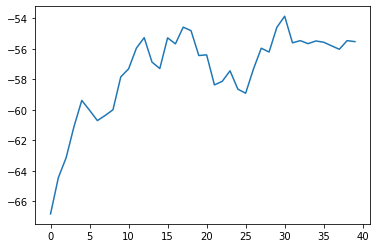

In [4]:
uga = UGA(cwgraph)
best, score, log = uga.run(0.1,0.1,40,20)
plt.plot(log)
plt.show()
best

In [9]:
trm = TRM()
trm.solve(cgraph,cwgraph,worker)[-1]

vington St & Ridge St|10 Ave & W 28 St'), ('51', 'Hancock St & Bedford Ave|Broadway & W 29 St'), ('51', 'W 37 St & 10 Ave|E 11 St & Broadway'), ('51', '9 Ave & W 18 St|W 26 St & 8 Ave'), ('51', '9 Ave & W 18 St1|DeKalb Ave & S Portland Ave'), ('51', '2 Ave & E 31 St|W 45 St & 6 Ave (1)'), ('51', 'E 20 St & 2 Ave22|Norfolk St & Broome St'), ('51', 'Lafayette Ave & St James Pl|W 54 St & 9 Ave'), ('51', 'South End Ave & Liberty St|Christopher St & Greenwich St'), ('51', 'E 39 St & 2 Ave|W 41 St & 8 Ave'), ('51', 'E 20 St & 2 Ave12|W 51 St & 6 Ave'), ('51', 'Columbia St & Rivington St|W 33 St & 7 Ave'), ('51', 'Madison St & Clinton St|Broadway & Berry St'), ('51', 'Washington Square E1|Murray St & West St'), ('51', '1 Ave & E 16 St|Harrison St & Hudson St'), ('51', 'Hicks St & Montague St11|8 Ave & W 31 St N'), ('51', 'Division St & Bowery|W 25 St & 6 Ave'), ('51', 'E 20 St & 2 Ave|NYCBS Depot - DEL'), ('51', 'Atlantic Ave & Fort Greene Pl|E 52 St & 2 Ave'), ('51', 'E 10 St & 5 Ave|Forsyth

KeyError: 'Broadway & W 58 St11'

In [6]:
lp_ = LP()
m,s =lp_.solve(cwgraph,worker,overflow,underflow)
s

Status: Optimal


29.993991867154495

In [7]:
lr = Local_Ratio()
lr.solve(cwgraph)[1]

100%|██████████| 119475/119475 [00:01<00:00, 60451.78it/s]
starting ratio
{"('0', 'University Pl & E 14 St', 'W 54 St & 9 Ave')": 0.0, "('0', 'University Pl & E 14 St', '8 Ave & W 33 St')": 0.0, "('0', 'University Pl & E 14 St', '10 Ave & W 28 St')": 0.0, "('0', 'University Pl & E 14 St', 'W 22 St & 8 Ave')": 0.0, "('0', 'University Pl & E 14 St', 'E 4 St & 2 Ave')": 0.0,
79
78
77
76
75
74
73
72
71
70
68
67
66
64
63
62
61
60
59
58
57
54
51
48
45
41
38
34
31
29
28
26
23
22
19
16
13
12
11
8
6
4
2
1
0


28.85030537965566

In [8]:
rsl = RSL()
rsl.optimize(cwgraph)

(<networkx.classes.graph.Graph at 0x7fb237bbdac0>, 30.762655234759844)

100%|██████████| 20/20 [00:01<00:00, 18.19it/s]


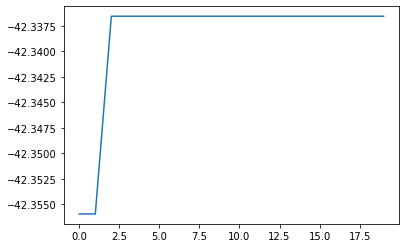

-42.33656224456949

In [9]:
uga2 = UGA_RSL(cwgraph)
graph,best,log = uga2.run(0.1,20,5)
plt.plot(log)
plt.show()
best